<a href="https://colab.research.google.com/github/annis/pBNN-for-stellarmass/blob/main/bnn11_for_stellarmass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making sense and evaluating the pBNN


Oct 19, 2021

In [ ]:
import numpy as np
import pandas as pd
from tqdm import trange
import time

#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# data splitting and outlier removal
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
# Set tensor numeric type.
dtype = 'float32'

# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools # to cycle through palette colors
if 1== 1 :
  sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
  )
sns.set_palette(palette='deep')

#sns.set_palette(palette="Paired_r")
#sns_c = sns.color_palette(palette="Paired_r")

%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Get TensorFlow version.
print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow Probability version: {tfp.__version__}')

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


TensorFlow version: 2.6.0
TensorFlow Probability version: 0.14.1


In [ ]:
from google.colab import files
uploaded=files.upload()

Saving cluster_data_0.3-0.6.csv to cluster_data_0.3-0.6.csv


In [ ]:
xname="sm_0.67"; yname="halo_mass"
xname="sm_1.0"; yname="halo_mass"; x2name="central_sm"

# gal_df = pd.read_csv("galaxies_near_clusters_0.3-0.6.csv") 
cluster_data = pd.read_csv("cluster_data_0.3-0.6.csv")
x_vector =  cluster_data[xname]; 
y_vector =  cluster_data[yname];
x2_vector = cluster_data[x2name]

# Set seed.
tf.random.set_seed(42)

# Tensors for tensorflow
# all the data

x = np.vstack([cluster_data[xname],cluster_data[x2name]]).transpose()
x = tf.convert_to_tensor(x, dtype=dtype)

y = tf.convert_to_tensor(cluster_data[yname], dtype=dtype)
y = tf.reshape(y, (-1, 1))
print("x shape: {}, y shape: {}".format(x.shape,y.shape))

# split into train and test sets
X=np.vstack([x_vector,x2_vector]).transpose()
X_train, X_test,  y_train, y_test = train_test_split(X, y_vector, train_size=160) # train_size=0.67)
print("train:  ",X_train.shape, y_train.shape," test:  ",  X_test.shape, y_test.shape)

# Tensors for tensorflow
# Just the train data
x = tf.convert_to_tensor(X_train, dtype=dtype)

y = tf.convert_to_tensor(y_train, dtype=dtype)
y = tf.reshape(y, (-1, 1))

x shape: (287, 2), y shape: (287, 1)
train:   (160, 2) (160,)  test:   (127, 2) (127,)


In [ ]:
def scale_and_rm_outliers(X_train, y_train, xname, x2name, yname) :   
    scaler = StandardScaler()
    detector = IsolationForest(n_estimators=1000,  contamination="auto", random_state=0)

    # Scaling
    unit_df =pd.DataFrame(data={xname:X_train[:,0], x2name:X_train[:,1], yname:y_train})
    # Scale data to zero mean and unit variance.
    X_t = scaler.fit_transform(unit_df)
    print("X_t shape",X_t.shape)

    # Remove outliers.
    detector = IsolationForest(n_estimators=1000,  contamination=0.15, random_state=0)
    is_inlier = detector.fit_predict(X_t)
    X_t = X_t[(is_inlier > 0),:]
    unit_df =pd.DataFrame(data={xname:X_t[:,0], x2name:X_t[:,1], yname:X_t[:,2]})

    # Inverse scaling
    X_t = scaler.inverse_transform(unit_df)
    inv_df=pd.DataFrame(data={xname:X_t[:,0], x2name:X_t[:,1], yname:X_t[:,2]})
    # xc=X_t[:,0]; x2c=X_t[:1] ;yc=X_t[:,2]
    
    # Tensors for tensorflow
    # Just the train data
    x = np.vstack([inv_df[xname],inv_df[x2name]]).transpose()
    x = tf.convert_to_tensor(x, dtype=dtype)

    y = tf.convert_to_tensor(inv_df[yname], dtype=dtype)
    y = tf.reshape(y, (-1, 1))

    if 1 == 0 :
        xt, yt = x,y
        x,y = tf.identity(xt), tf.identity(yt)
        #x = tf.reshape(x, (5,1,32,-1))
        #y = tf.reshape(y, (5,1,32,-1))

        print("xt shape: {}, yt shape: {}".format(xt.shape,yt.shape))
        print("x shape: {}, y shape: {}".format(x.shape,y.shape))
        
    return X_t, x, y

## Plotting codes

In [ ]:
def plot_boxplot(posterior_samples):
  fig, axes = plt.subplots(1, 4, figsize=(16, 4))

  # Invert the results dict for easier plotting.
  #k = list(posterior_samples.values())[0].keys()
  k = list(posterior_samples.keys())
  #print("p,k:", posterior_samples["HMC"].keys(), posterior_samples.keys())
  type_keys = posterior_samples.keys()
  for tkey in type_keys:
    var_keys=posterior_samples[tkey].keys()
    
  vlist = []
  for vkey in var_keys:
    tlist = []
    for tkey in type_keys :
        #print (vkey, tkey, "   = ", posterior_samples[tkey][vkey].shape)
        tlist.append(posterior_samples[tkey][vkey])
    vlist.append( [vkey, type_keys, tlist] )  

  for i, (var, tvar, var_results) in enumerate(vlist):
    sns.boxplot(data=list(var_results), ax=axes[i],
                width=0.18*len(var_results), whis=(2.5, 97.5))
    # axes[i].boxplot(list(var_results.values()), whis=(2.5, 97.5))
    axes[i].title.set_text(var)
    fs = 10 if len(var_results) < 4 else 8
    axes[i].set_xticklabels(tvar, fontsize=fs)  
    
def plot_chain_traces(params, num_chains, chains_df) :
    fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

    for i, param in enumerate(params):
        if num_chains < 6 :
            sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
        else :
            sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, bins=70,  
                         ax=axes[i][0], legend=False)
        sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', 
                     alpha=0.3, legend=False, ax=axes[i][1])

    fig.suptitle('Posterior Samples per Chain', y=1.03);
 
def plot_chain_sum(params, chains_df) :
    fig, axes = plt.subplots(nrows=int((len(params)/2.)), 
            ncols=2, figsize=(9, 6), constrained_layout=True)
    
    palette = itertools.cycle(sns.color_palette())
    # color
    c = next(palette)

    ii=0; jj=0
    for i, param in enumerate(params):
        sns.histplot(x=param, data=chains_df, kde=True, ax=axes[ii][jj], color=c)
        axes[ii][jj].axvline(
            x=chains_df[param].mean(), 
            linestyle='--',
            color="black",
            label='mean = {:10.3f}\nstd     = {:10.3f}'.format(
                chains_df[param].mean(),chains_df[param].std())
        )
        axes[ii][jj].legend(loc='upper right') 
        c = next(palette)
        jj+=1; 
        if jj==2: 
            jj=0; ii+=1

    fig.suptitle('Posterior Samples', y=1.03);
    
# for wide spread use
# ppd_df is the output of make_posterior_predictive_distribution
def yp_on_yt_plot (y_predictions, y_sigma, y_test, ppd_df) :
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), constrained_layout=True)

    ax[0].errorbar( x=np.array(y_test), y=y_predictions, yerr=y_sigma,fmt='o',
        ecolor="r", mfc="r", mec="k", capsize=2, label='predictions + credible intervals')
    sns.regplot(x=np.array(y_test), y=y_predictions,
        scatter=False, line_kws=dict(alpha=0.5), fit_reg=True, label="linear regression", 
        truncate=False, ax=ax[0])
    ax[0].plot(ppd_df["range"],ppd_df["mean"], color="black", label="y=x, 90% posterior predictive")
    ax[0].fill_between(ppd_df["range"], ppd_df["90l"], ppd_df["90u"], color='k', alpha=.1)
    ax[0].set(title='Model Predictions for Test Sample', xlabel='y',ylabel='y_pred');
    ax[0].legend(loc='lower right')
         
    ax[1].errorbar( x=np.array(y_test), y=y_predictions-np.array(y_test), yerr=y_sigma,fmt='o', 
        #ecolor=sns_c[1], mfc=sns_c[4],
        ecolor="r", mfc="r", mec="k", capsize=2, label='predictions + credible intervals',)
    sns.regplot(x=np.array(y_test), y = y_predictions-np.array(y_test),
        scatter=False, line_kws=dict(alpha=0.5),  fit_reg=True, label="linear regression",  
        truncate=False,  ax=ax[1])
    ax[1].plot(ppd_df["range"],np.zeros(ppd_df["mean"].size), 
               color="black", label="y=x, 90% posterior predictive")
    ax[1].fill_between(ppd_df["range"], ppd_df["90l"]-ppd_df["mean"], ppd_df["90u"]-ppd_df["mean"], color='k', alpha=.1)
    ax[1].set(title='Delta Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
    ax[1].legend(loc='lower right')

# this is probably a special purpose HMC code
def plot_hmc_distributions(answers, y_test) :
    plt.figure(figsize=(12, 8))
    residuals = answers["posterior_mean"]-y_test

    mu_post_dist = answers["mu_posterior_dist"]
    post_dist = answers["posterior_dist"]
    shapes = post_dist.get_shape().as_list()

    # Get y_test into a shape that can be subtracted to every entry in post_dist
    yt = tf.constant(y_test, dtype=dtype)
    yt = tf.broadcast_to(yt, [shapes[1],shapes[0]])
    yt = tf.transpose(yt)

    # make them all residuals
    post_dist = post_dist-yt
    mu_post_dist = mu_post_dist-yt
    # get rid of structure now that they are all residuals
    post_dist = tf.squeeze(tf.reshape(post_dist, [1,-1]))
    mu_post_dist = tf.squeeze(tf.reshape(mu_post_dist, [1,-1]))

    #fig.legend(loc="upper right")
    #fig.suptitle('Posterior Samples', y=1.03);
    sns.histplot(x=post_dist, kde=True, stat="density", color="blue", alpha=0.75)
    sns.histplot(x=mu_post_dist, kde=True, stat="density", color="green", alpha=0.45)
    sns.histplot(x=residuals, kde=False, stat="density", color="black", alpha=0.35)
 # 

## Definitions for re-use


In [ ]:
def chains_to_df (chain, num_chains, params) :
    print("\n==== chains_to_df is dependent on the order & number of parameters in the chain\n")
    i = 0; dict= {}
    dict[params[0]] =  chain[0][:,i].numpy()
    dict[params[1]] =  chain[1][...,0][:,i].numpy()
    dict[params[2]] =  chain[1][...,1][:,i].numpy()
    dict[params[3]] =  chain[2][:,i].numpy()
    size = chain[0][:,i].numpy().size
    dict["chain_id"]= (np.ones(size)*(i+1)).astype("int")
    dict["chain_sample_id"]= range(size) 
    for i in range(1,num_chains) :
        dict[params[0]] = np.append(dict[params[0]], chain[0][:,i].numpy() )
        dict[params[1]] = np.append(dict[params[1]], chain[1][...,0][:,i].numpy() )
        dict[params[2]] = np.append(dict[params[2]], chain[1][...,1][:,i].numpy() )    
        dict[params[3]] = np.append(dict[params[3]], chain[2][:,i].numpy() )
        dict["chain_id"] = np.append(dict["chain_id"], (np.ones(size)*(i+1)).astype("int"))
        dict["chain_sample_id"] = np.append(dict["chain_sample_id"], range(size))
                                 
    chains_df = pd.DataFrame(dict)
    return chains_df

def make_posterior_means_from_chains(chains, X_test, y_test , params, verbose=False) :
    x_star = tf.cast(tf.squeeze(X_test), dtype)
    alpha_ch = chains[0]
    beta_ch  = chains[1]
    sigma_ch = chains[2]
    # stack all the chains into one long tensor, for each alpnh,beta,sigma
    alpha = tf.squeeze(tf.reshape(alpha_ch, [-1,1]))
    sigma = tf.squeeze(tf.reshape(sigma_ch, [-1,1]))
    beta = tf.squeeze(tf.reshape(beta_ch, [-1,1,2]))

    if verbose: 
      print("X_test  ", X_test.shape)
      print("x_star  ", x_star.shape)
      print("alpha  ", alpha.shape)
      print("beta  ", beta.shape)
      print("sigma  ", sigma.shape)
    # shapes_ch = alpha_ch.get_shape().as_list()
    # size = shapes_ch[0]*shapes_ch[1]

    # Here we compute mu = alpha + beta x.
    beta_x = tf.linalg.matmul(x_star, tf.transpose(beta) )
    if verbose: 
      print("beta_x  ", beta_x.shape)

    # compute mcmc posterior predictive distribution 
    mu_y_pred = alpha + beta_x
    if verbose: print("mu_y_star  ", mu_y_pred.shape)
    
    mu_posterior_mean = tf.math.reduce_mean(mu_y_pred, axis=1).numpy()
    mu_posterior_std = tf.math.reduce_std(mu_y_pred, axis=1).numpy()
    if verbose:print ("mu_posterior_mean  ",mu_posterior_mean.shape)

    # compute posterior predictive distribution from mu_posterior_mean and 
    # the chain computed sigma
    ppd_y_pred = tf.map_fn(
        fn=lambda z: tfd.Normal(loc=z, scale=sigma).sample(1), 
        elems=mu_posterior_mean    )
    ppd_y_pred = tf.squeeze(ppd_y_pred)
    if verbose: print("ppd_y_pred  ", ppd_y_pred.shape)

    posterior_mean = tf.math.reduce_mean(ppd_y_pred, axis=1).numpy()
    posterior_std = tf.math.reduce_std(ppd_y_pred, axis=1).numpy()
    if verbose: print ("posterior_mean  ",posterior_mean.shape)

    mu_chisq = (((mu_posterior_mean-y_test)/mu_posterior_std)**2).sum()/(y_test.size-len(params)-1)
    mu_rms = np.sqrt(((mu_posterior_mean-y_test)**2).sum()/y_test.size)
    chisq = (((posterior_mean-y_test)/posterior_std)**2).sum()/(y_test.size-len(params)-1)
    rms = np.sqrt(((posterior_mean-y_test)**2).sum()/y_test.size)

    print("\n Test data\n")
    print ("mu_posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(mu_chisq,mu_rms))
    print ("   posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(chisq, rms))

    # prepare the fit and confidence interval: weirdly, assuming that the only thing that matters is sigma
    # becuse it is a posterior predictive distribution 
    ppd_df = make_posterior_predictive_distribution (tf.math.reduce_mean(sigma))

    answers={}
    answers["mu_posterior_mean"] = mu_posterior_mean
    answers["mu_posterior_std"] = mu_posterior_std
    answers["mu_posterior_dist"] = mu_y_pred
    answers["posterior_mean"] = posterior_mean
    answers["posterior_std"] = posterior_std
    answers["posterior_dist"] = ppd_y_pred
    answers["ppd_df"] = ppd_df

    return answers

def make_posterior_predictive_distribution (sigma, verbose=False) :
    # prepare the fit and confidence interval: weirdly, assuming that the only thing that matters is sigma
    # becuse it is a posterior predictive distribution 
    range_x = np.arange(14.0,15.0,0.05) ; 
    if verbose : print("range_x: ", range_x.shape)
    range_y = tf.map_fn(
        fn=lambda z: tfd.Normal(loc=z, scale=sigma).sample(20000), 
        elems=tf.constant(range_x , dtype=dtype )  )
    range_y = tf.squeeze(range_y)
    if verbose: print("range_y  ", range_y.shape)

    range_mean = tf.math.reduce_mean(range_y, axis=1).numpy()
    range_std = tf.math.reduce_std(range_y, axis=1).numpy()
    range_90l = range_mean - 2*range_std
    range_90u = range_mean + 2*range_std
    df = pd.DataFrame({"mean": range_mean})
    df["range"]= range_x
    df["std"]= range_std
    df["90l"]= range_90l
    df["90u"]= range_90u
    return df
#

## Define the physical model

In [ ]:
#tf.keras.backend.clear_session()
# Define the probabilistic graphical model as a JointDistribution.
def out_y_point (alpha, beta, x) :
    beta = tf.reshape(beta,[2,-1])
    return tf.linalg.matmul(x, beta) + alpha
def out_y (alpha, beta, sigma, x) :
    return tfd.Normal( loc=out_y_point(alpha, beta, x), scale=sigma, name="y")

@tfd.JointDistributionCoroutineAutoBatched
def model_standard():
    alpha = yield  tfd.Normal( loc=5.0, scale=10.0, name="alpha")
    beta =  yield tfd.Normal( loc=[0.0,0.0], scale=[3.0,3.0], name="beta")
    sigma = yield tfd.HalfNormal(scale=1.0, name="sigma")                                   
    y = yield  out_y(alpha, beta, sigma, x)
    
@tfd.JointDistributionCoroutineAutoBatched
def model_yyz():
    alpha = yield  tfd.Normal( loc=3.0, scale=6.0, name="alpha")
    beta =  yield tfd.Normal( loc=[0.0,0.0], scale=[3.0,3.0], name="beta")
    sigma = yield tfd.HalfNormal(scale=1.0, name="sigma")
    q = yield tfd.Normal ( loc=0.0, scale=1.0, name="q")                                   
    y = yield  out_y(alpha, beta, (sigma + q* (out_y_point(alpha, beta, x)-12.0)), x)
    
@tfd.JointDistributionCoroutineAutoBatched
def model_vector():
    alpha = yield  tfd.Normal( loc=3.0, scale=6.0, name="alpha")
    beta =  yield tfd.Normal( loc=[0.0,0.0], scale=[3.0,3.0], name="beta")
    sigma = yield tfd.HalfNormal(
                loc=(out_y_point(alpha,beta,x)-12.0), 
                scale=tf.math.softplus( 0.005*(out_y_point(alpha,beta,x)-12.0)) + 0.001, 
                name="sigma")                                
    y = yield  out_y(alpha, beta, sigma, x)
    
def pack_samples(samples):
  try :
    dict= {'alpha': samples.alpha,
          'beta0': samples.beta[...,0],
          'beta1': samples.beta[...,1],
          'sigma': samples.sigma,
          }
  except :
    dict= {'alpha': samples["alpha"],
          'beta0': samples["beta0"],
          'beta1': samples["beta1"],
          'sigma': samples["sigma"],
          }
  return dict

params = ["beta0", "beta1", "alpha", "sigma"];# wonder how to get this automatically
    
model = model_standard
target_model = model.experimental_pin(y=y)

print("model.event_shape: \n",model.event_shape)
print( target_model.event_shape_tensor())

model.event_shape: 
 StructTuple(
  alpha=TensorShape([]),
  beta=TensorShape([2]),
  sigma=TensorShape([]),
  y=TensorShape([160, 1])
)
StructTuple(
  alpha=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  beta=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
  sigma=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>
)


## Ground truth: Hamiltonian Monte Carlo (HMC)

We use HMC to generate "ground truth" samples from the true posterior, for comparison with results of the surrogate posteriors.

In [ ]:
num_chains = 10
num_leapfrog_steps = 3
step_size = 1.0

# Size of each chain.
num_steps = int(3e4)
num_steps = int(1e4)
# Burn-in steps.
num_burnin_steps = int(2e5)
num_burnin_steps = int(2e6)

# reset the model????
target_model = model.experimental_pin(y=y)

def setup_mc (target_model, num_chains, num_steps, num_burnin_steps, num_leapfrog_steps) :
    
    flat_event_shape = tf.nest.flatten(target_model.event_shape)
    enum_components = list(range(len(flat_event_shape)))
    bijector = tfb.Restructure(
        enum_components,
        tf.nest.pack_sequence_as(target_model.event_shape, enum_components))(
            target_model.experimental_default_event_space_bijector())

    current_state = bijector(
        tf.nest.map_structure(
            lambda e: tf.zeros([num_chains] + list(e), dtype=tf.float32),
        target_model.event_shape))

    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_model.unnormalized_log_prob,
        #num_leapfrog_steps=num_leapfrog_steps,
        #step_size=[tf.fill(s.shape, step_size) for s in current_state])
        step_size=1.0,
        num_leapfrog_steps=3)

    hmc = tfp.mcmc.TransformedTransitionKernel(hmc, bijector)
    hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(hmc,
        num_adaptation_steps=int(num_burnin_steps * 0.8),
        target_accept_prob=0.3)
    return hmc, current_state

hmc, current_state = setup_mc(
    target_model, num_chains, num_steps, num_burnin_steps, num_leapfrog_steps)

start=time.time()
chain, is_accepted = tf.function(
    lambda current_state: tfp.mcmc.sample_chain(
        current_state=current_state,
        kernel=hmc,
        num_results=num_steps,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, pkr: (pkr.inner_results.inner_results.is_accepted),
    ),
    autograph=False,
    jit_compile=True)(current_state)

accept_rate = tf.reduce_mean(tf.cast(is_accepted, tf.float32))
ess = tf.nest.map_structure(
    lambda c: tfp.mcmc.effective_sample_size(
        c,
        cross_chain_dims=1,
        filter_beyond_positive_pairs=True),
    chain)
end = time.time()
print("HMC time: {:2f} seconds".format(end - start))

r_hat = tf.nest.map_structure(tfp.mcmc.potential_scale_reduction, chain)
hmc_samples = pack_samples(tf.nest.pack_sequence_as(target_model.event_shape, chain))
print('Acceptance rate is {}'.format(accept_rate))

vars= []
for var, var_samples in hmc_samples.items(): vars.append(var)
print(vars)
#

HMC time: 64.563750 seconds
Acceptance rate is 0.2883400022983551
['alpha', 'beta0', 'beta1', 'sigma']


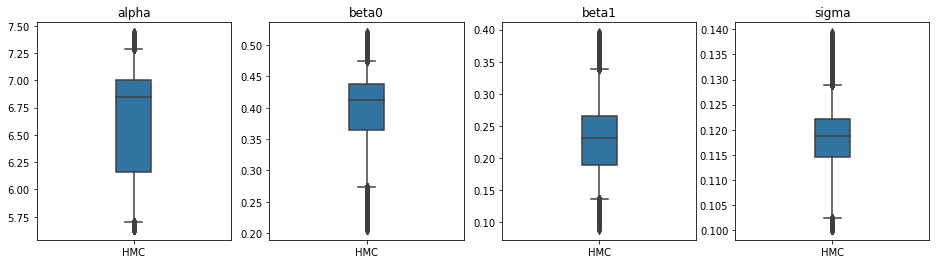

In [ ]:
results = {'HMC': pack_samples(hmc_samples)}
#results["HMC"]
plot_boxplot(results)
#


==== chains_to_df is dependent on the order & number of parameters in the chain



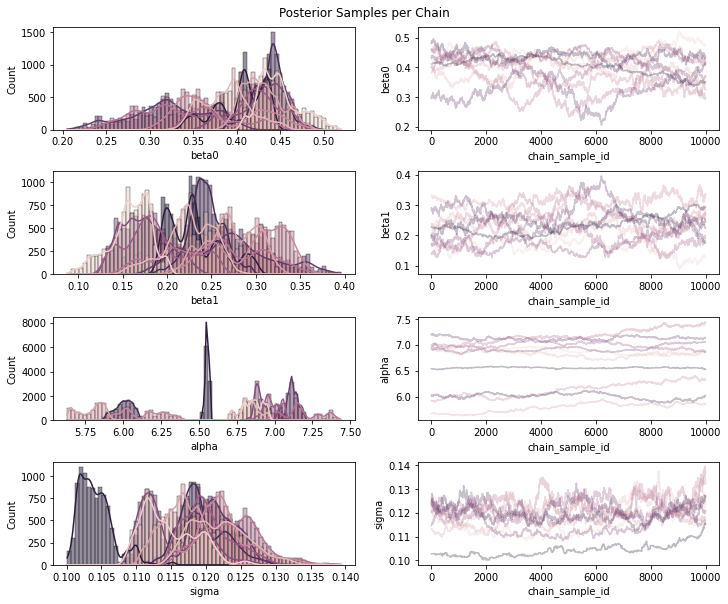

In [ ]:
chains_df = chains_to_df(chain, num_chains, vars)
# chains_df
plot_chain_traces(params, num_chains, chains_df)
#

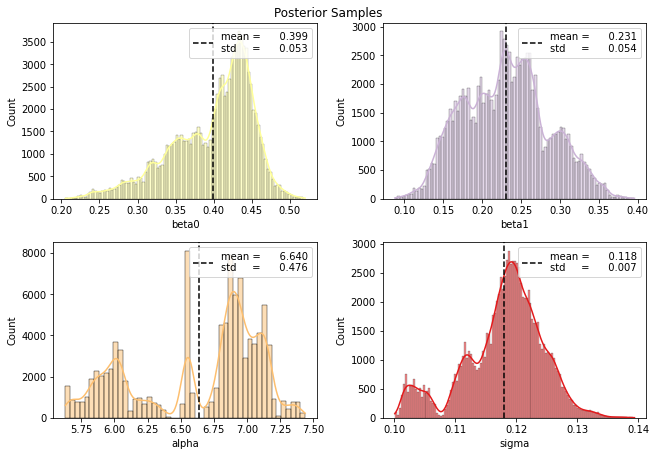

In [ ]:
plot_chain_sum(params, chains_df )
#


 Test data

mu_posterior_std  chi-sq and rms:  74.96  0.115
   posterior_std  chi-sq and rms:   0.99  0.115


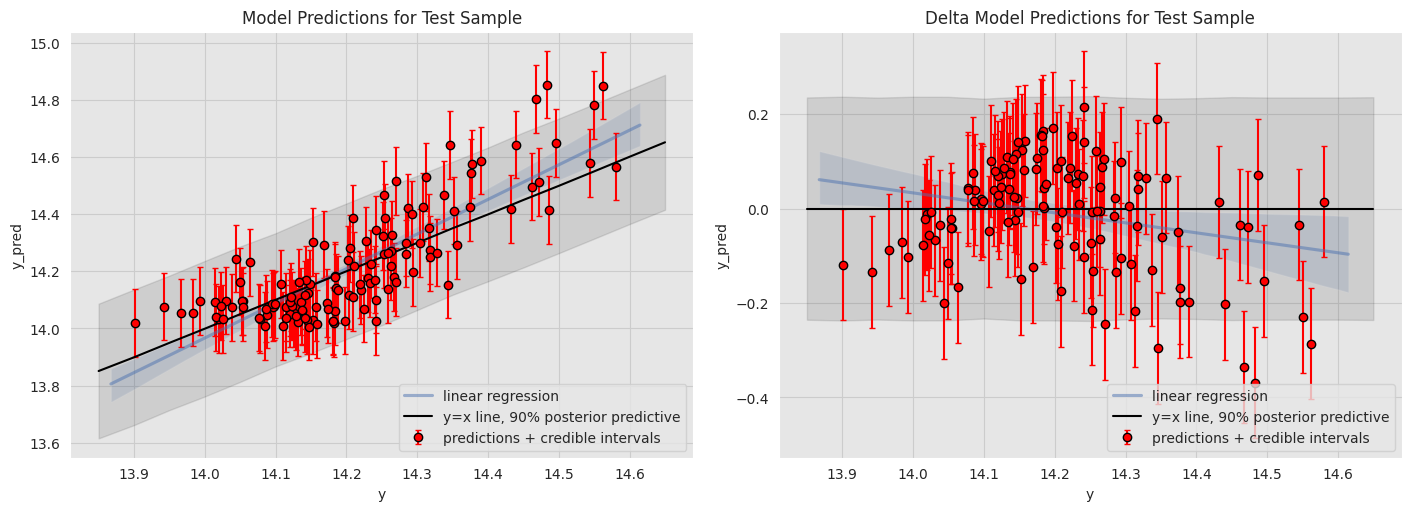

In [ ]:
answers = make_posterior_means_from_chains(chain, X_test, y_test, params, verbose=False)    
yp_on_yt_plot (answers["posterior_mean"], answers["posterior_std"], y_test, answers["ppd_df"])
#

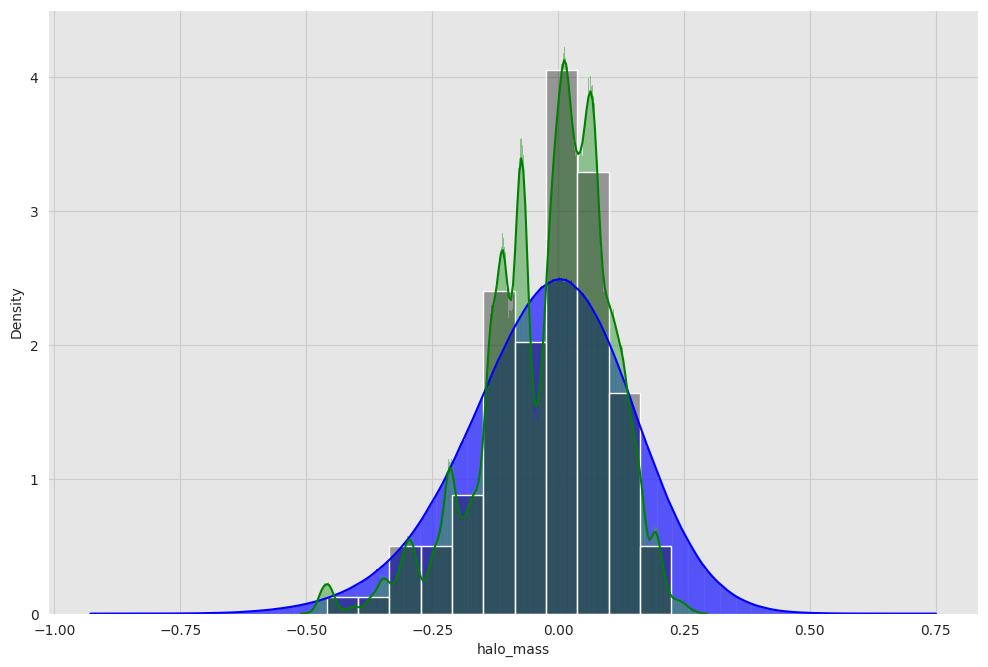

In [ ]:
plot_hmc_distributions(answers, y_test)

#

## Variational Inference



In [ ]:
# target_model is set when one sets the model earlier in the noebook.


# Determine the `event_shape` of the posterior, and calculate the size of each
# `event_shape` component. These determine the sizes of the components of the
# underlying standard Normal distribution, and the dimensions of the blocks in
# the blockwise matrix transformation.
event_shape = target_model.event_shape_tensor()
flat_event_shape = tf.nest.flatten(event_shape)
flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)

print("event_shape:  ", event_shape)
print("\n\nflat_event_shape:")
for fes in flat_event_shape:
  print(fes)
print("\n\nflat_event_size:")
for fes in flat_event_size:
  print(fes)

# The `event_space_bijector` maps unconstrained values (in R^n) to the support
# of the prior -- we'll need this at the end to constrain Multivariate Normal
# samples to the prior's support.
event_space_bijector = target_model.experimental_default_event_space_bijector()

base_standard_dist = tfd.JointDistributionSequential(
      [tfd.Sample(tfd.Normal(0., 1.), s) for s in flat_event_size])

#block_tril_linop = (
#    tfp.experimental.vi.util.build_trainable_linear_operator_block(
#        operators, flat_event_size))
#scale_bijector = tfb.ScaleMatvecLinearOperatorBlock(block_tril_linop)

loc_bijector = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))


reshape_bijector = tfb.JointMap(
   tf.nest.map_structure(tfb.Reshape, flat_event_shape))
unflatten_bijector = tfb.Restructure(
       tf.nest.pack_sequence_as(
           event_shape, range(len(flat_event_shape))))

# event_space_bijector = target_model.experimental_default_event_space_bijector()

# Reshape each component to match the prior, using a nested structure of
# `Reshape` bijectors wrapped in `JointMap` to form a multipart bijector.
reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape))

# Restructure the flat list of components to match the prior's structure
unflatten_bijector = tfb.Restructure(
        tf.nest.pack_sequence_as(
            event_shape, range(len(flat_event_shape))))



event_shape:   StructTuple(
  alpha=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  beta=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
  sigma=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>
)


flat_event_shape:
tf.Tensor([], shape=(0,), dtype=int32)
tf.Tensor([2], shape=(1,), dtype=int32)
tf.Tensor([], shape=(0,), dtype=int32)


flat_event_size:
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)


### Change the form of the posterior surrogate to Mean Field

In [ ]:
# A block-diagonal linear operator, in which each block is a diagonal operator,
# transforms the standard Normal base distribution to produce a mean-field
# surrogate posterior.
operators = (tf.linalg.LinearOperatorDiag,
             tf.linalg.LinearOperatorDiag,
             tf.linalg.LinearOperatorDiag)

block_tril_linop = (
    tfp.experimental.vi.util.build_trainable_linear_operator_block(
        operators, flat_event_size))
scale_bijector = tfb.ScaleMatvecLinearOperatorBlock(block_tril_linop)
event_space_bijector = target_model.experimental_default_event_space_bijector()

block_diag_linop = (
    tfp.experimental.vi.util.build_trainable_linear_operator_block(
        operators, flat_event_size))
mean_field_scale = tfb.ScaleMatvecLinearOperatorBlock(block_diag_linop)

mean_field_loc = tfb.JointMap(
    tf.nest.map_structure(
        lambda s: tfb.Shift(
            tf.Variable(tf.random.uniform(
                (s,), minval=-2., maxval=2., dtype=tf.float32))),
        flat_event_size))

mean_field_surrogate_posterior = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector, # reshape the vector-valued components to match the shapes of the posterior components
         mean_field_loc,   # allow for nonzero mean
         mean_field_scale  # apply the block matrix transformation to the standard Normal distribution
         ]))


Instructions for updating:
Do not call `graph_parents`.


In [ ]:
surrogate_posterior = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the posterior components
         loc_bijector,  # allow for nonzero mean
         scale_bijector  # apply the block matrix transformation to the standard Normal distribution
         ]))



optimizing time: 9.915846 seconds
Mean-field surrogate posterior ELBO: 89.17491149902344


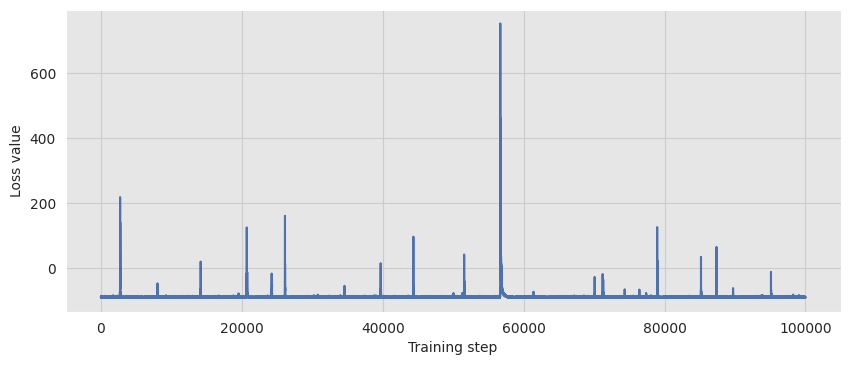

In [ ]:
tf.keras.backend.clear_session()
target_model = model.experimental_pin(y=y)

start = time.time()
optimizer=tf.optimizers.Adam(learning_rate=1e-3)
mean_field_loss = tfp.vi.fit_surrogate_posterior(
    target_model.unnormalized_log_prob,
    mean_field_surrogate_posterior,
    optimizer=optimizer,
    #num_steps=10**4,
    num_steps=10**5,
    sample_size=16,
    jit_compile=True)
end = time.time()
print("optimizing time: {:2f} seconds".format(end - start))

mean_field_samples = mean_field_surrogate_posterior.sample(1000)
mean_field_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*mean_field_samples)
    - mean_field_surrogate_posterior.log_prob(mean_field_samples))
print('Mean-field surrogate posterior ELBO: {}'.format(mean_field_final_elbo))

plt.figure(figsize=(10, 4))
plt.plot(mean_field_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')


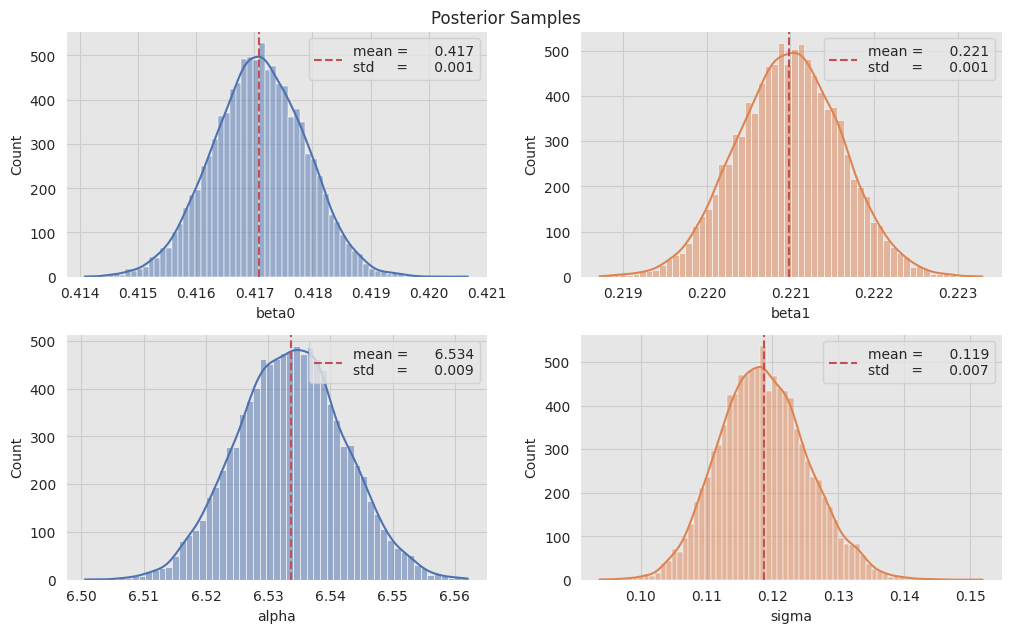

In [ ]:
mfs_samples = mean_field_surrogate_posterior.sample(10000)

alpha = mfs_samples[0].numpy()
beta = mfs_samples[1].numpy()
sigma =mfs_samples[2].numpy()

df = pd.DataFrame({"sigma":sigma,"alpha":alpha, "beta0":beta[:,0], "beta1":beta[:,1]})

params=["beta0","beta1","alpha","sigma"]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), constrained_layout=True)

for param, i, j in zip(params, [0,1,0,1,],[0,0,1,1]):
    sns.histplot(x=param, data=df, color=sns_c[i], kde=True, ax=ax[j][i])
    ax[j][i].axvline(
        x=df[param].mean(), 
        color=sns_c[3], 
        linestyle='--',
        label='mean = {:10.3f}\nstd     = {:10.3f}'.format(df[param].mean(),df[param].std() )
    )
    ax[j][i].legend(loc='upper right')    
fig.suptitle('Posterior Samples', y=1.03);


 Test data

   posterior_std  chi-sq and rms:   1.30  0.133


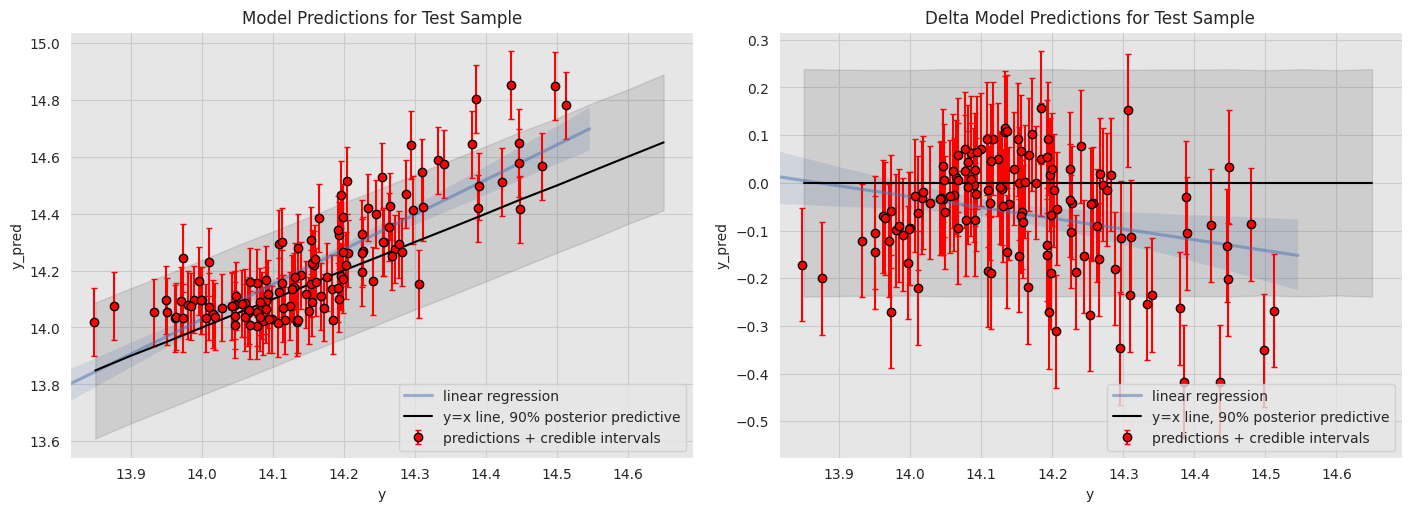

In [ ]:
def get_y_predictions(alpha, beta, sigma, x) :
    beta = tf.reshape(beta,[2,-1])
    return tfd.Normal( loc=tf.linalg.matmul(x, beta) + alpha, scale=sigma)

y_model = get_y_predictions(alpha, beta, sigma, tf.convert_to_tensor(X_test, dtype=dtype))
posterior_mean =( y_model.mean()).numpy().mean(axis=1)
posterior_std = ( y_model.stddev()).numpy().mean(axis=1)

chisq = (((posterior_mean-y_test)/posterior_std)**2).sum()/(y_test.size-len(params)-1)
rms = np.sqrt(((posterior_mean-y_test)**2).sum()/y_test.size)

print("\n Test data\n")
print ("   posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(chisq, rms))

# posterior predictive distribution 
ppd_df = make_posterior_predictive_distribution (sigma.mean())
yp_on_yt_plot (posterior_mean, posterior_std, y_test, ppd_df)

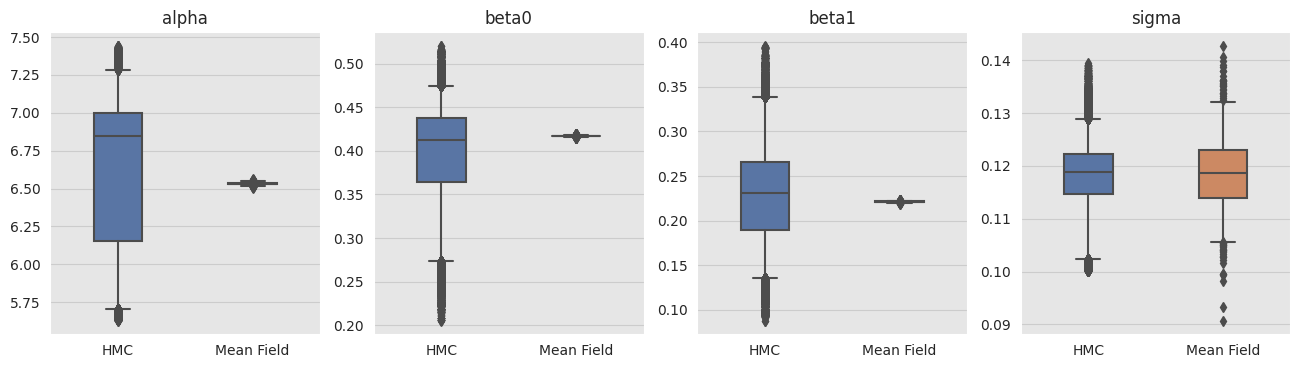

In [ ]:
results['Mean Field'] = pack_samples(mean_field_samples)
plot_boxplot(results)
#

### Change the form of the posterior surrogate to Multivariate Gaussian

In [ ]:
operators = (
    (tf.linalg.LinearOperatorDiag,),  # Variance of sigma
    (tf.linalg.LinearOperatorFullMatrix,  tf.linalg.LinearOperatorDiag),  # Variance of alpha.
     # Covariance between sigma  and alpha.
     (tf.linalg.LinearOperatorFullMatrix, tf.linalg.LinearOperatorFullMatrix,  tf.linalg.LinearOperatorLowerTriangular)
    # covariance beta+alpha                 covariance beta+sigma                 independence among beta
    )

print("operators shape:", np.shape(operators))


scale_bijector = tfb.ScaleMatvecLinearOperatorBlock(block_tril_linop)
event_space_bijector = target_model.experimental_default_event_space_bijector()

operators shape: (3,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
surrogate_posterior = tfd.TransformedDistribution(
    base_standard_dist,
    bijector = tfb.Chain(  # Note that the chained bijectors are applied in reverse order
        [
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the posterior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the posterior components
         loc_bijector,  # allow for nonzero mean
         scale_bijector  # apply the block matrix transformation to the standard Normal distribution
         ]))


optimizing time: 160.830604 seconds
Multivariate Normal surrogate posterior ELBO: 88.51605224609375


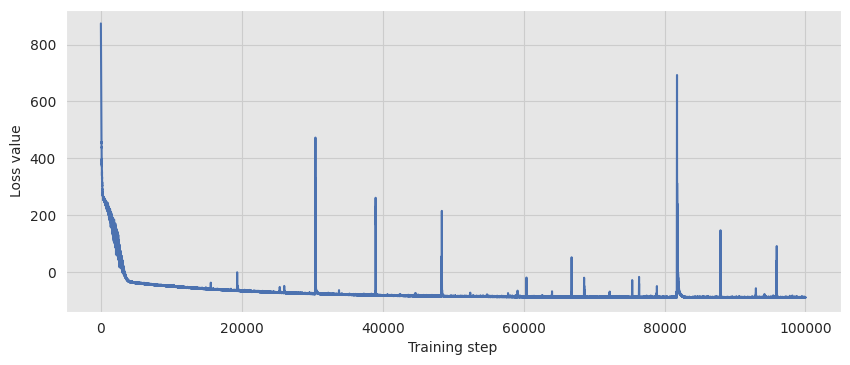

In [ ]:
target_model = model.experimental_pin(y=y)

start = time.time()
optimizer = tf.optimizers.Adam(learning_rate=1e-3)
mvn_loss = tfp.vi.fit_surrogate_posterior(
    target_model.unnormalized_log_prob,
    surrogate_posterior,
    optimizer=optimizer,
    #num_steps=10**4,
    num_steps=10**5,
    sample_size=16)
end = time.time()
print("optimizing time: {:2f} seconds".format(end - start))

mvn_samples = surrogate_posterior.sample(1000)
mvn_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*mvn_samples)
    - surrogate_posterior.log_prob(mvn_samples))

print('Multivariate Normal surrogate posterior ELBO: {}'.format(mvn_final_elbo))

plt.figure(figsize=(10, 4))
plt.plot(mvn_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')


 Test data

   posterior_std  chi-sq and rms:   1.30  0.133


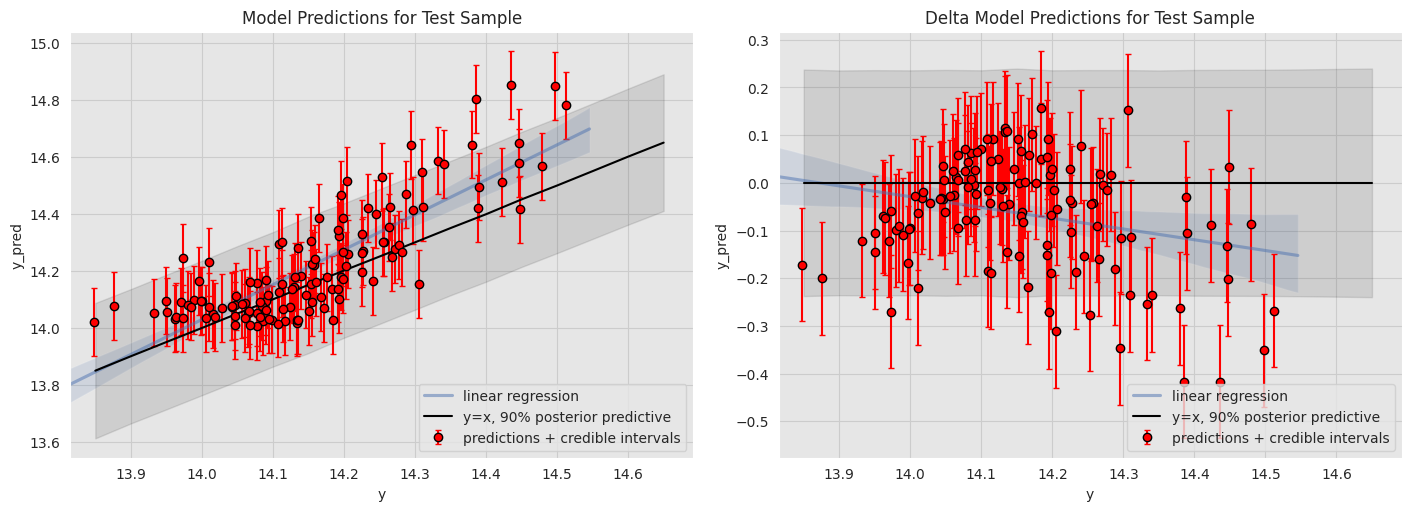

In [ ]:
def get_y_predictions(alpha, beta, sigma, x) :
    beta = tf.reshape(beta,[2,-1])
    return tfd.Normal( loc=tf.linalg.matmul(x, beta) + alpha, scale=sigma)

mvn_samples = surrogate_posterior.sample(10000)
alpha = mfs_samples[0].numpy()
beta = mfs_samples[1].numpy()
sigma =mfs_samples[2].numpy()

y_model = get_y_predictions(alpha, beta, sigma, tf.convert_to_tensor(X_test, dtype=dtype))
posterior_mean =( y_model.mean()).numpy().mean(axis=1)
posterior_std = ( y_model.stddev()).numpy().mean(axis=1)

chisq = (((posterior_mean-y_test)/posterior_std)**2).sum()/(y_test.size-len(params)-1)
rms = np.sqrt(((posterior_mean-y_test)**2).sum()/y_test.size)

print("\n Test data\n")
print ("   posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(chisq, rms))

# posterior predictive distribution 
ppd_df = make_posterior_predictive_distribution (sigma.mean())
yp_on_yt_plot (posterior_mean, posterior_std, y_test, ppd_df)

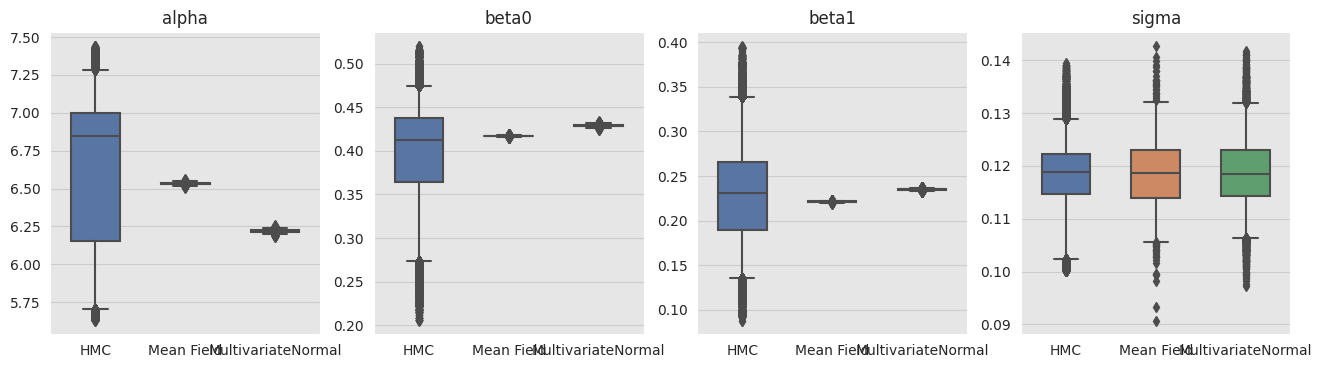

In [ ]:
results['MultiN'] = pack_samples(mvn_samples)
plot_boxplot(results)
#

### Change the form of the posterior surrogate to Inverse Autoregressive Flow surrogate posterior

In [ ]:
# Build a standard Normal with a vector `event_shape`, with length equal to the
# total number of degrees of freedom in the posterior.
base_distribution = tfd.Sample(
    tfd.Normal(0., 1.), sample_shape=[tf.reduce_sum(flat_event_size)])

# Apply an IAF to the base distribution.
num_iafs = 2
iaf_bijectors = [
    tfb.Invert(tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(
            params=2, hidden_units=[256, 256], activation='relu')))
    for _ in range(num_iafs)
]

# Split the base distribution's `event_shape` into components that are equal
# in size to the prior's components.
split = tfb.Split(flat_event_size)

# Chain these bijectors and apply them to the standard Normal base distribution
# to build the surrogate posterior. `event_space_bijector`,
# `unflatten_bijector`, and `reshape_bijector` are the same as in the
# multivariate Normal surrogate posterior.
iaf_surrogate_posterior = tfd.TransformedDistribution(
    base_distribution,
    bijector=tfb.Chain([
         event_space_bijector,  # constrain the surrogate to the support of the prior
         unflatten_bijector,  # pack the reshaped components into the `event_shape` structure of the prior
         reshape_bijector,  # reshape the vector-valued components to match the shapes of the prior components
         split] +  # Split the samples into components of the same size as the prior components
         iaf_bijectors  # Apply a flow model to the Tensor-valued standard Normal distribution
         ))


optimizing time: 128.790406 seconds
IAF surrogate posterior ELBO: 94.19879913330078


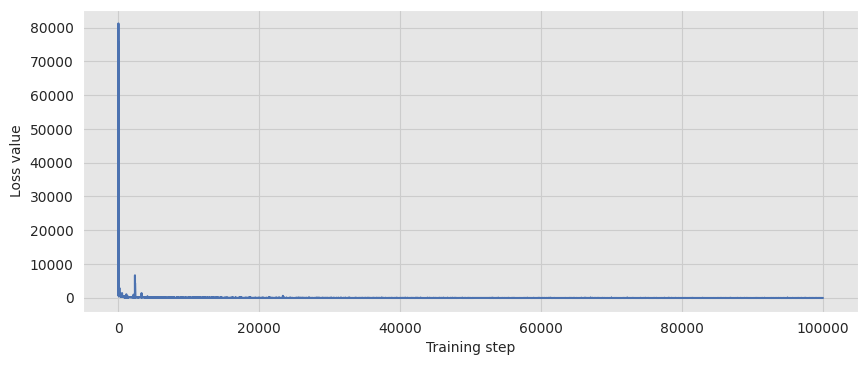

In [ ]:
target_model = model.experimental_pin(y=y)

start = time.time()
optimizer=tf.optimizers.Adam(learning_rate=1e-3)
iaf_loss = tfp.vi.fit_surrogate_posterior(
  target_model.unnormalized_log_prob,
  iaf_surrogate_posterior,
  optimizer=optimizer,
  #num_steps=10**4,
  num_steps=10**5,
  sample_size=4,
  jit_compile=True)
end = time.time()
print("optimizing time: {:2f} seconds".format(end - start))

iaf_samples = iaf_surrogate_posterior.sample(1000)
iaf_final_elbo = tf.reduce_mean(
    target_model.unnormalized_log_prob(*iaf_samples)
    - iaf_surrogate_posterior.log_prob(iaf_samples))
print('IAF surrogate posterior ELBO: {}'.format(iaf_final_elbo))

plt.figure(figsize=(10, 4))
plt.plot(iaf_loss)
plt.xlabel('Training step')
_ = plt.ylabel('Loss value')





 Test data

   posterior_std  chi-sq and rms:   1.30  0.133


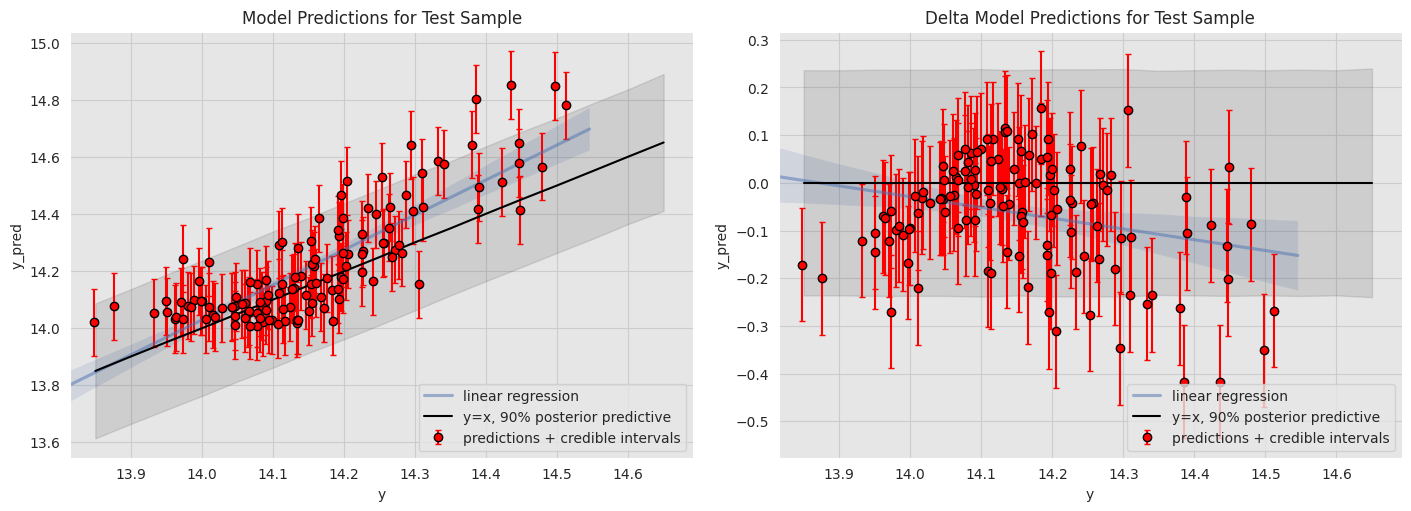

In [ ]:
def get_y_predictions(alpha, beta, sigma, x) :
    beta = tf.reshape(beta,[2,-1])
    return tfd.Normal( loc=tf.linalg.matmul(x, beta) + alpha, scale=sigma)

mvn_samples = iaf_surrogate_posterior.sample(10000)
alpha = mfs_samples[0].numpy()
beta = mfs_samples[1].numpy()
sigma =mfs_samples[2].numpy()

y_model = get_y_predictions(alpha, beta, sigma, tf.convert_to_tensor(X_test, dtype=dtype))
posterior_mean =( y_model.mean()).numpy().mean(axis=1)
posterior_std = ( y_model.stddev()).numpy().mean(axis=1)

chisq = (((posterior_mean-y_test)/posterior_std)**2).sum()/(y_test.size-len(params)-1)
rms = np.sqrt(((posterior_mean-y_test)**2).sum()/y_test.size)

print("\n Test data\n")
print ("   posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(chisq, rms))

# posterior predictive distribution 
ppd_df = make_posterior_predictive_distribution (sigma.mean())
yp_on_yt_plot (posterior_mean, posterior_std, y_test, ppd_df)

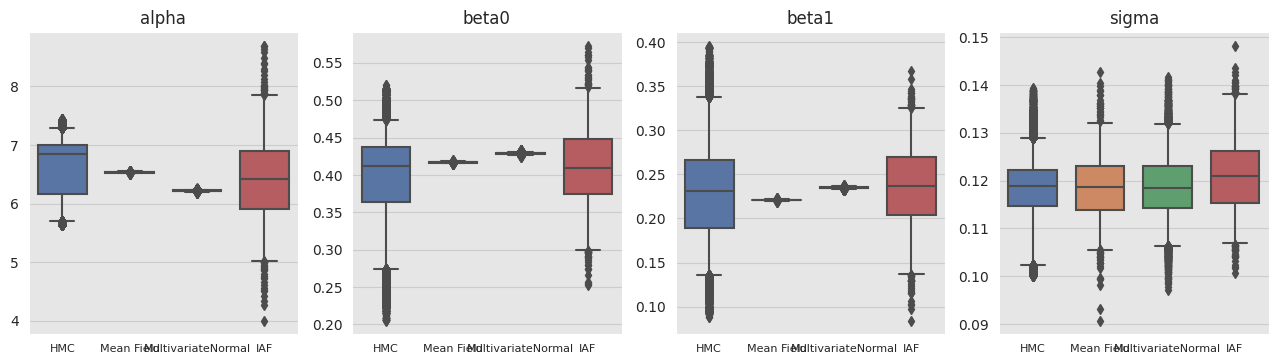

In [ ]:
results['IAF'] = pack_samples(iaf_samples)
plot_boxplot(results)
#

## Probabilistic Bayesian Neural Networks

In [ ]:
# simple NN regresion
model = tf.keras.Sequential([tf.keras.layers.Dense(1)])
# Do inference.
start=time.time()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss="mean_squared_error")
model.fit(x, y, epochs=3000, verbose=False)
end= time.time()
print("Train time: {:.1f} seconds".format(end-start))

y_fit = np.squeeze(model.predict(X_test))

#plt.figure(figsize=(16, 5))
#sns.scatterplot(x=x_test,y=y_fit, color="r")

model.summary()
print("model.layers[0].get_weights():\n {} \n".format( model.layers[0].get_weights()))
model.layers[0].weights

Train time: 14.0 seconds
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
model.layers[0].get_weights():
 [array([[0.42499274],
       [0.32528135]], dtype=float32), array([5.106878], dtype=float32)] 



[<tf.Variable 'dense_23/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[0.42499274],
        [0.32528135]], dtype=float32)>,
 <tf.Variable 'dense_23/bias:0' shape=(1,) dtype=float32, numpy=array([5.106878], dtype=float32)>]

This regression gives after 3000 epoch fit, beta_0 = 0.42, beta_1= 0.32. This is in relatively good agreement with the HMC.

Interesting.   

model = tf.keras.Sequential([tf.keras.layers.Dense(1)])

Which gives two slopes and one bias: $$0.42*sm_{1.0} + 0.32*sm_{cen} + 5.1 = halo_{mass}$$

In [ ]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
# kernel seems to be number of x_params * number of model_params
# bias seems to be number of x_params
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype, name="posterior"),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1), name="posterior-dl"),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype, name="prior"),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1), name="prior-dl"),
  ])
  

In [ ]:
# Build model.
negloglik = lambda y, p_y: -p_y.log_prob(y)

model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable,                            
        kl_weight=1/x.shape[0], use_bias=True, name="DenseVariational"),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
 # tfp.layers.DistributionLambda(
 #    lambda t: tfd.Normal(loc=t[..., :1],scale=1))                    
])

start=time.time()
# Do inference.
# for distributionLambda = pBNN
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
# for non-distribution lambda = BNN
#model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss="mean_squared_error")
model.fit(x, y, epochs=300, verbose=False);
end = time.time()
print("PBNN1 time: {:2f} seconds".format(end - start))

model.summary()
print("model.layers[0].get_weights():\n {} \n".format( model.layers[0].get_weights()))
model.layers[0].weights

PBNN1 time: 3.493445 seconds
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
DenseVariational (DenseVaria (32, 2)                   18        
_________________________________________________________________
distribution_lambda_25 (Dist multiple                  0         
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________
model.layers[0].get_weights():
 [array([ 0.57918596,  2.5259113 ,  0.58047444,  2.526191  ,  0.5936696 ,
        2.5224333 , -3.6171048 ,  0.06258165, -3.303102  , -0.88012815,
       -2.1018004 ,  0.18171524], dtype=float32), array([0.55689836, 2.1802742 , 0.59334207, 2.614867  , 0.63394284,
       2.4823842 ], dtype=float32)] 



[<tf.Variable 'DenseVariational/constant:0' shape=(12,) dtype=float32, numpy=
 array([ 0.57918596,  2.5259113 ,  0.58047444,  2.526191  ,  0.5936696 ,
         2.5224333 , -3.6171048 ,  0.06258165, -3.303102  , -0.88012815,
        -2.1018004 ,  0.18171524], dtype=float32)>,
 <tf.Variable 'DenseVariational/constant:0' shape=(6,) dtype=float32, numpy=
 array([0.55689836, 2.1802742 , 0.59334207, 2.614867  , 0.63394284,
        2.4823842 ], dtype=float32)>]

Exploring whether we can understand weights as in model parameters. Other than simple 1 layer linear regression, no, no it isn't possble. They are just weights in a network, not beta_0 and beta_1 encoded.

In [ ]:
dir(model.layers[0])

print(model.layers[0].name_scope())
print("====")
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()
for name, weight in zip(names, weights):
    print(name, weight.shape)
print("====")

n_w_layers = len (model.layers[0].weights)
for n in range(n_w_layers): print("n: {}  model.layers[0].weights[{}]: {} ".format(n,n, model.layers[0].weights[n] ))


DenseVariational/
====
DenseVariational/constant:0 (12,)
DenseVariational/constant:0 (6,)
====
n: 0  model.layers[0].weights[0]: <tf.Variable 'DenseVariational/constant:0' shape=(12,) dtype=float32, numpy=
array([ 0.57918596,  2.5259113 ,  0.58047444,  2.526191  ,  0.5936696 ,
        2.5224333 , -3.6171048 ,  0.06258165, -3.303102  , -0.88012815,
       -2.1018004 ,  0.18171524], dtype=float32)> 
n: 1  model.layers[0].weights[1]: <tf.Variable 'DenseVariational/constant:0' shape=(6,) dtype=float32, numpy=
array([0.55689836, 2.1802742 , 0.59334207, 2.614867  , 0.63394284,
       2.4823842 ], dtype=float32)> 


In [ ]:
# Build model for purely epistemic i.e., BNN
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])
## Build model for aleatoric and epistemic i.e., pBNN
model3 = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])


# Do inference.
start=time.time()
model3.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model3.fit(x, y, epochs=3000, verbose=False)
end= time.time()
print("Train time: {:.1f} seconds".format(end-start))

y_fit = np.squeeze(model3.predict(X_test))

plt.figure(figsize=(16, 5))
sns.scatterplot(x=y_test,y=y_fit, color="r")

# Make predictions.
# yhats = [model(x_test) for i in range(100)]
model3.summary()
model=model3

Train time: 27.4 seconds


ValueError: ignored

In [ ]:
# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
#assert isinstance(yhat, tfd.Distribution)
model.summary()

[ 1.6498607 -3.266308 ]
[  9.783991 109.30514 ]
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 2)                 4         
_________________________________________________________________
distribution_lambda_12 (Dist multiple                  0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[0].get_weights()
#dir(model.layers[0])
#model.layers[0].bias
#model.layers[0].count_params()
model.layers[0].weights
#model.layers[0].units
model.weights

[<tf.Variable 'dense_10/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[ 1.6498607, -3.266308 ]], dtype=float32)>,
 <tf.Variable 'dense_10/bias:0' shape=(2,) dtype=float32, numpy=array([  9.783991, 109.30514 ], dtype=float32)>]

yhat (127, 100)
posterior_mean (127,)

Test data
posterior_std  chi-sq and rms:   0.95  0.141


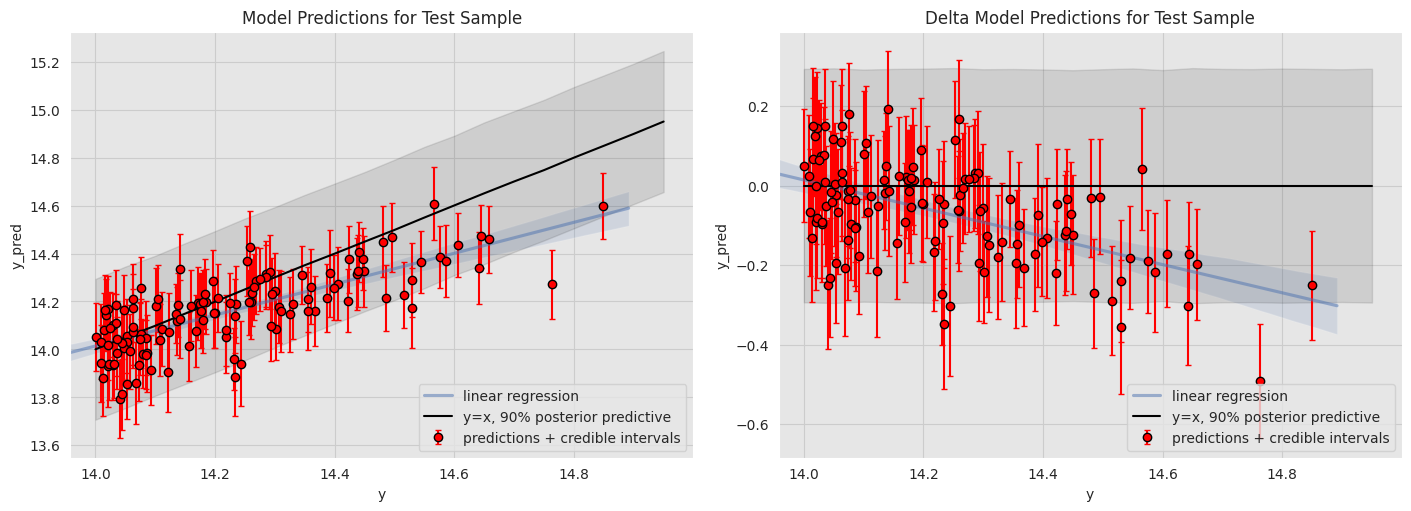

In [ ]:
yhat  = tf.transpose(tf.squeeze(model(X_test).sample(100)))
posterior_mean = tf.math.reduce_mean(yhat,axis=1).numpy()
posterior_std = tf.math.reduce_std(yhat,axis=1).numpy()
print ("yhat", yhat.shape)
print ("posterior_mean", posterior_mean.shape)

chisq = (((posterior_mean-y_test)/posterior_std)**2).sum()/(y_test.size-len(params)-1)
rms = np.sqrt(((posterior_mean-y_test)**2).sum()/y_test.size)

print("\nTest data")
print ("posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(chisq, rms))

# posterior predictive distribution 
ppd_df = make_posterior_predictive_distribution (posterior_std.mean())
yp_on_yt_plot (posterior_mean, posterior_std, y_test, ppd_df)

#print("y_test min,max: {:.2f} {:.2f} ".format(y_test.min(), y_test.max()))
#print("y_train min,max: {:.2f} {:.2f} ".format(y_train.min(), y_train.max()))

In [ ]:
for n in [10**2,10**4,10**5] :
  initial = X_test[0:1,:]
  sample = np.repeat(initial,n,axis=0)
  pm = tf.squeeze(model.predict(sample))
  pmr= pm-y_test.iloc[1]
  print("mean:  {:.3f}.  std:  {:.3f}".format(tf.math.reduce_mean(pmr),tf.math.reduce_std(pmr)))



mean:  0.573.  std:  0.592
mean:  0.480.  std:  0.609
mean:  0.474.  std:  0.596


(100,) <class 'numpy.ndarray'>
(400,) <class 'numpy.ndarray'>
(1400,) <class 'numpy.ndarray'>


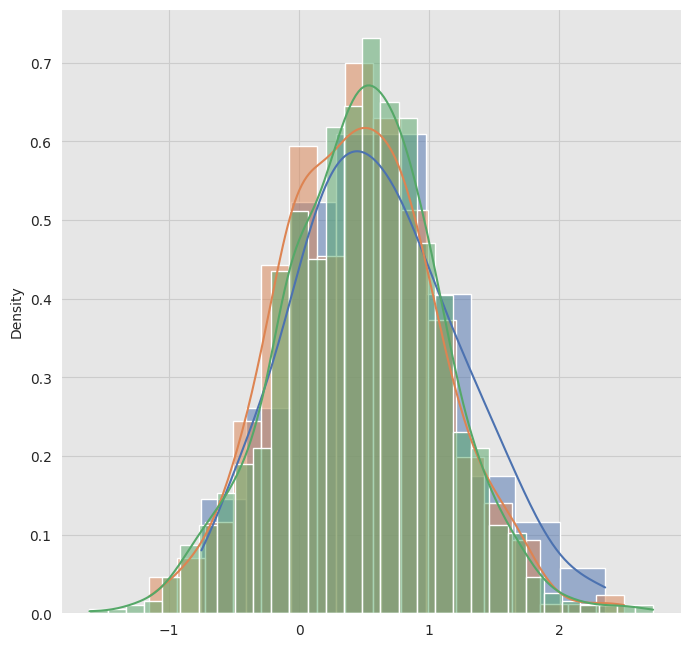

In [ ]:
plt.figure(figsize=(8, 8))
palette = itertools.cycle(sns.color_palette())
c = next(palette)

v = np.array([])
for n in [10**2,3*10**2,10**3] :
  #yhat  = tf.transpose(tf.squeeze(model(X_test[0:2,:]).sample(n)))

  for j in range(n):
    #pm = model.predict(X_test[0:1,:])
    pm = model(X_test[0:1,:], training=False)
    pmr= pm[0,0]-y_test.iloc[1]
    v = np.append(v,pmr)
  print(v.shape, type(v)); pmr=np.array(v)

  #fig.legend(loc="upper right")
  #fig.suptitle('Posterior Samples', y=1.03);
  sns.histplot(x=pmr, kde=True, stat="density", color=c); 
  c = next(palette)


I know think that this data set is bad for model-less = NN models because the numbers of data points decreases so rapidly from one side of the regression to another.

## Let's do a PNN with a linear known data set to understand the sampling

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in power


x_test, y_test:    (223,) (223,)


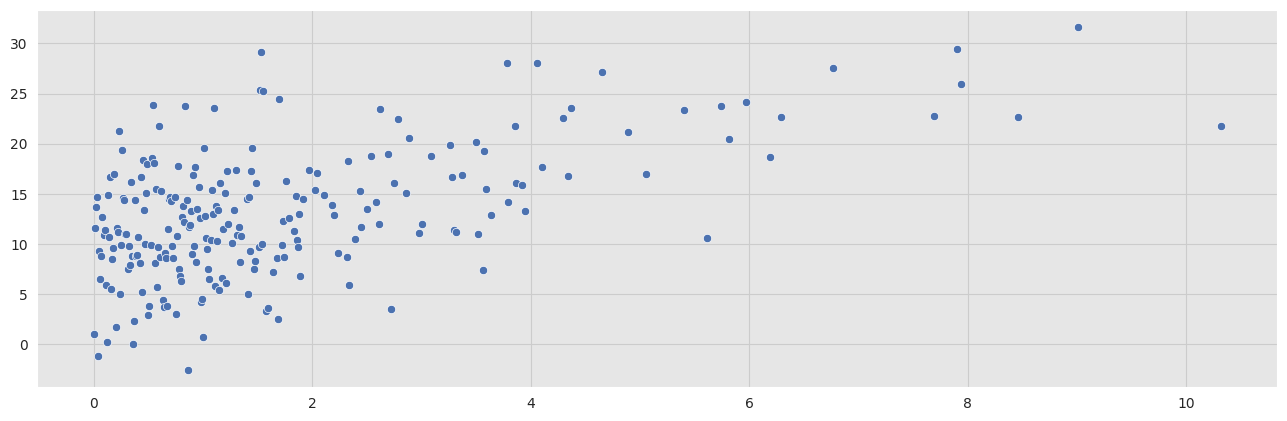

In [ ]:
x = np.arange(0,10.5,0.01)
a = 10
b = 1.618
sigma = 2.71828*2
y = a + b*x + np.random.normal(loc=0.0, scale=sigma, size = x.size)
ix = np.random.uniform(size=x.size) < 1/(x**1.6) 
x=x[ix]; y = y[ix]

#print(x.size)
plt.figure(figsize=(16, 5))
sns.scatterplot(x=x,y=y)
#x_test = np.arange(10.5,20.5,0.01)
x_test = np.arange(0,10.5,0.01)
x_test +=  np.random.normal(loc=0.0, scale=0.1, size = x_test.size)

y_test = a + b*x_test + np.random.normal(loc=0.0, scale=sigma, size = x_test.size)

ix = np.random.uniform(size=x_test.size) < 1/(x_test**1.6)
x_test=x_test[ix]; y_test = y_test[ix]

print("x_test, y_test:   ",x_test.shape, y_test.shape)

Train time: 41.3 seconds
(223, 2)


Exception: ignored

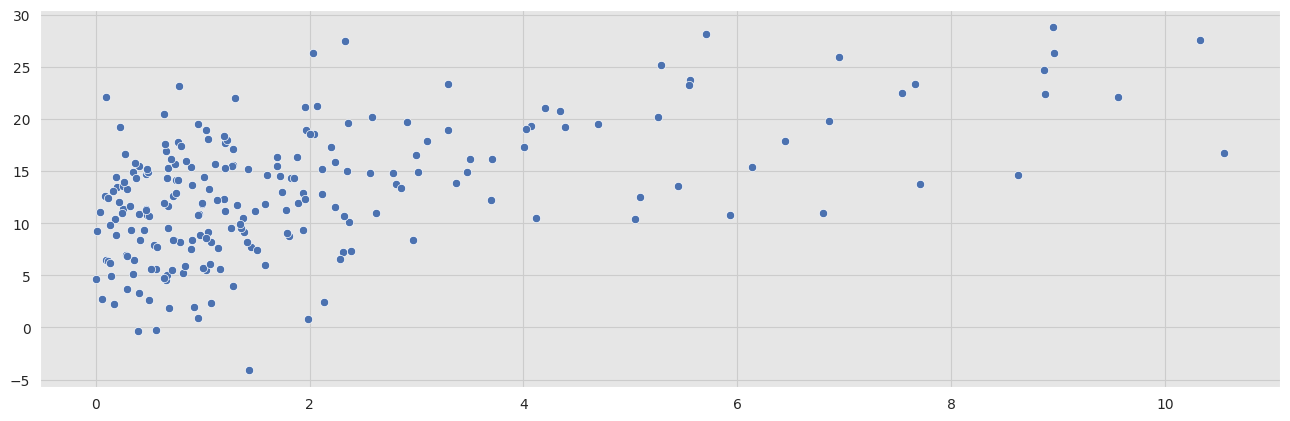

In [ ]:
# a linear regression model Heterodestic

model = tf.keras.Sequential([
  tf.keras.layers.Dense(units=(1 + 1), use_bias=True),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
])
negloglik = lambda y, p_y: -p_y.log_prob(y)

# Do inference.
start=time.time()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
#model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss="mean_squared_error")
model.fit(x, y, epochs=300, verbose=False)
end= time.time()
print("Train time: {:.1f} seconds".format(end-start))

y_fit = np.squeeze(model.predict(x_test))

print(y_fit.shape)
plt.figure(figsize=(16, 5))
sns.scatterplot(x=x_test,y=y_test)
sns.scatterplot(x=x_test,y=y_fit, color="r")

model.summary()
print("model.layers[0].get_weights():\n {} \n".format( model.layers[0].get_weights()))
model.layers[0].weights



In [ ]:
print(model.summary())
model.layers[0].get_weights()
#dir(model.layers[0])
#model.layers[0].bias
#model.layers[0].count_params()
print("model.layers[0].get_weights():\n {} \n".format( model.layers[0].get_weights()))
#model.layers[0].units
#model.weights
model.layers[0].weights

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 2)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________
None
model.layers[0].get_weights():
 [array([[2.067911, 2.067911]], dtype=float32), array([9.806025, 9.806025], dtype=float32)] 



[<tf.Variable 'dense_20/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[2.067911, 2.067911]], dtype=float32)>,
 <tf.Variable 'dense_20/bias:0' shape=(2,) dtype=float32, numpy=array([9.806025, 9.806025], dtype=float32)>]

Train time: 41.9 seconds
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_24 (DenseV (None, 1)                 6         
_________________________________________________________________
distribution_lambda_54 (Dist multiple                  0         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


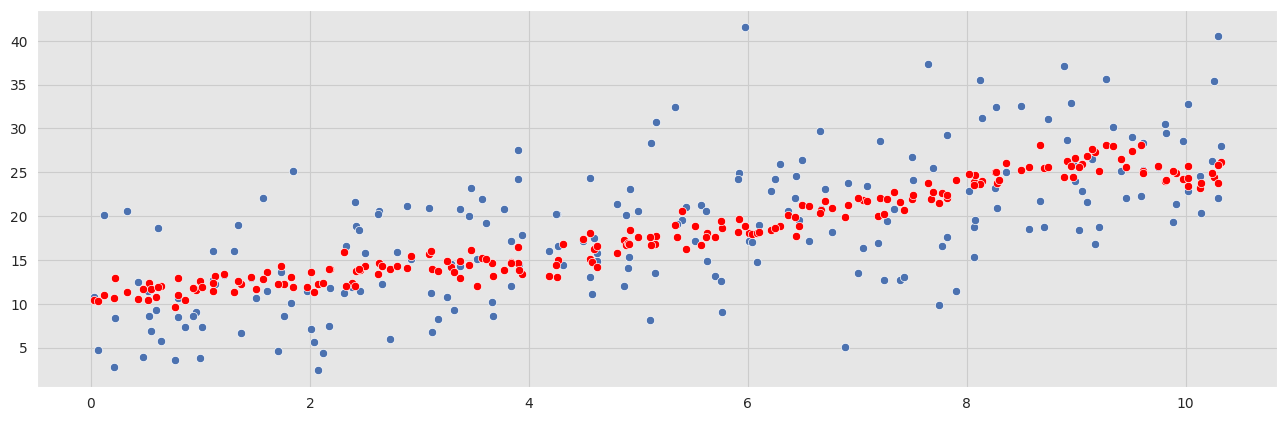

In [ ]:
# Build model for purely epistemic i.e., BNN
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])


model2 = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
start=time.time()
model2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model2.fit(x, y, epochs=3000, verbose=False)
end= time.time()
print("Train time: {:.1f} seconds".format(end-start))

y_fit = np.squeeze(model2.predict(x_test))

plt.figure(figsize=(16, 5))
sns.scatterplot(x=x_test,y=y_test)
sns.scatterplot(x=x_test,y=y_fit, color="r")

# Make predictions.
# yhats = [model(x_test) for i in range(100)]
model2.summary()

Train time: 19.3 seconds
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_23 (DenseV (None, 2)                 12        
_________________________________________________________________
distribution_lambda_53 (Dist multiple                  0         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


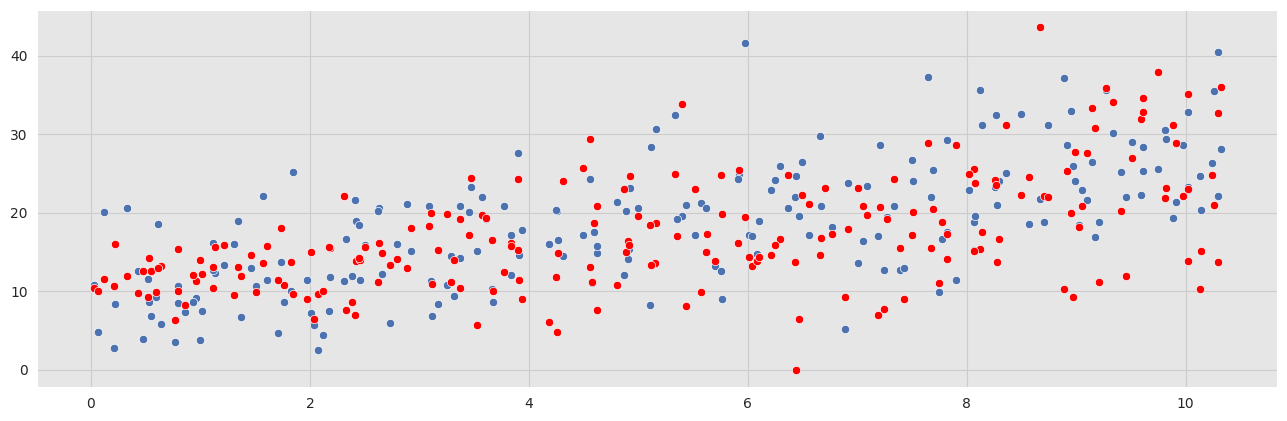

In [ ]:
## Build model for aleatoric and epistemic i.e., pBNN
model3 = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])


# Do inference.
start=time.time()
model3.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model3.fit(x, y, epochs=3000, verbose=False)
end= time.time()
print("Train time: {:.1f} seconds".format(end-start))

y_fit = np.squeeze(model3.predict(x_test))

plt.figure(figsize=(16, 5))
sns.scatterplot(x=x_test,y=y_test)
sns.scatterplot(x=x_test,y=y_fit, color="r")

# Make predictions.
# yhats = [model(x_test) for i in range(100)]
model3.summary()

xto, yto:    (216,) (216,)
yhat (65016,).  3.2 seconds.    mean offset:  0.63  std:  7.27 
yhat (6696,).  0.3 seconds.    mean offset:  0.71  std:  7.36 


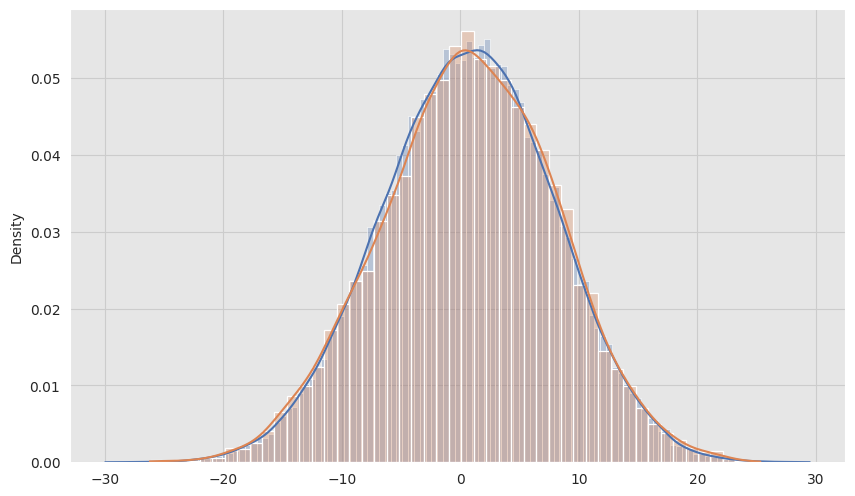

In [ ]:
use_model = model

plt.figure(figsize=(10, 6))
palette = itertools.cycle(sns.color_palette())
c = next(palette)

xto = x_test
yto = y_test

print("xto, yto:   ", xto.shape, yto.shape)
for n in [3*10**2,  30] :
#for n in [10**2,] :
  xt = xto; yt = yto
  start=time.time()
  for n2 in range(n):
      xt = np.hstack((xt,xto))
      yt = np.hstack((yt,yto))
  yhat  = tf.squeeze(use_model.predict(xt))
  yhat = yhat-yt
  sns.histplot(x=yhat, kde=True,  stat="density", color=c, alpha=0.3); 
  c = next(palette)
  end= time.time()
  print("yhat {}.  {:.1f} seconds.    mean offset:  {:.2f}  std:  {:.2f} ".format(
      yhat.shape,  end-start, yhat.numpy().mean(), yhat.numpy().std()))
